Сначала сделаю регрессию, потом классификацию.

# Регрессиия 

## Бейзлайн случайного леса регрессии

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt




In [2]:
# Загружаем датасет
df = pd.read_csv("diamonds.csv")

In [3]:
import sklearn
print(sklearn.__version__)

1.3.2


In [4]:
# Разделяем признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

# Разделяем на числовые и категориальные признаки
X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(include=['object'])

# Кодируем категориальные признаки
X_categorical_encoded = X_categorical.copy()
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Объединяем признаки
X_processed = pd.concat([X_numeric, X_categorical_encoded], axis=1)


In [5]:


# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

# Список для сохранения результатов
results_rf_reg = []

# Создаём и обучаем случайный лес
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf_reg.predict(X_test)

In [6]:


# Метрики
r2 = r2_score(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Базовый Random Forest",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

# Выводим метрики
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2: 0.9999
RMSE: 40.6464
MAE: 3.5400


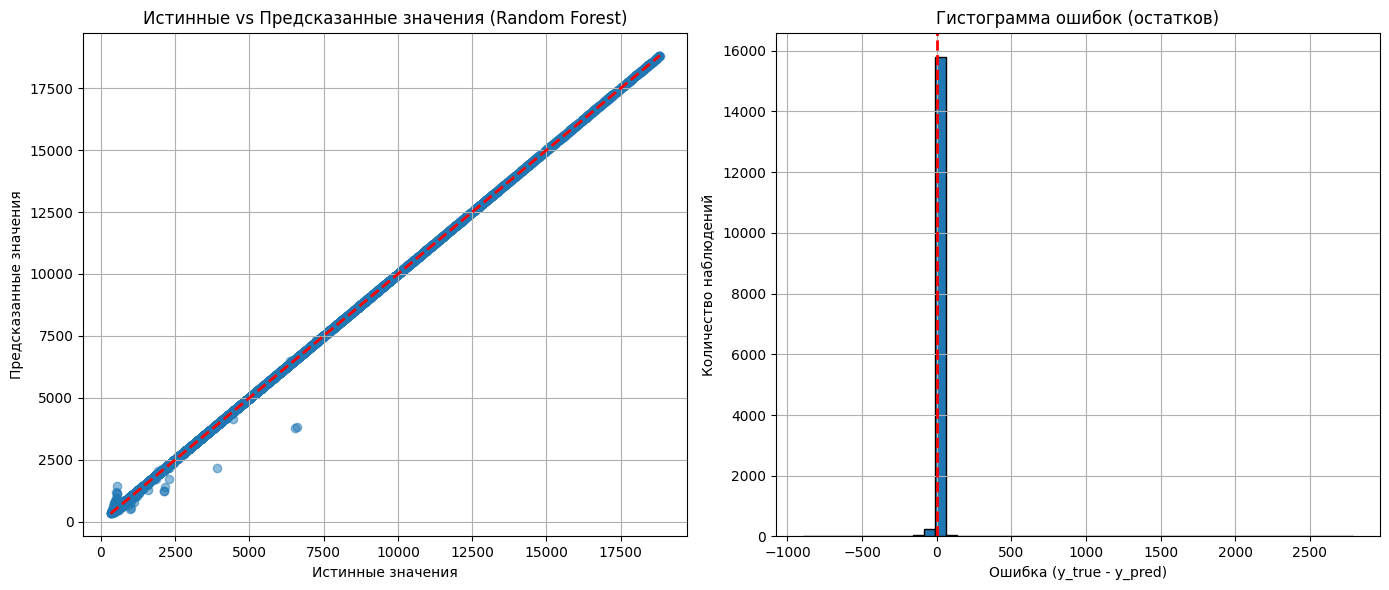

In [7]:


# Остатки
residuals = y_test - y_pred_rf

# Графики
plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Истинные vs Предсказанные значения (Random Forest)")
plt.grid(True)

# 2. Гистограмма остатков
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.axvline(0, linestyle='--', color='red', lw=2)
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.title("Гистограмма ошибок (остатков)")
plt.grid(True)

plt.tight_layout()
plt.show()

Как и в случае с решающем деревом мы видимо слишком хорошие показатели метрик. Посмотрим с помощью кросс-валидации есть ли у нас переобучение или нет

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold

# Категориальные признаки через OneHotEncoder
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), X_categorical.columns)
], remainder='passthrough')

X_encoded = preprocessor.fit_transform(X)

# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

r2_scores = cross_val_score(rf_reg, X_encoded, y, cv=kf, scoring='r2', n_jobs=-1)

print("R2 по фолдам кросс-валидации:", r2_scores)
print("Среднее R2:", r2_scores.mean())

R2 по фолдам кросс-валидации: [0.99995767 0.99992962 0.99994238 0.99995694 0.99993594]
Среднее R2: 0.9999445123127402


Что ж, проверка кросс-валидацией показала что переобучения нет. Значения в каждом фофолде примерно одинаковые и нигде не проседают. Попробую предложить какие-нибудь гипотезы, чтобы улучшить модель, хотя боюсь может последующее улучшение приведет к переобучению. Но в целом есть куда стремиться, мы можем наблдюдать небольшое количество выбросов при небольших значениях цены, постараюсь их исправить.

# Гипотезы

## Гипотеза 1: сегментация по цене

## Гипотеза 2: добавление взаимодействий и полиномиальных признаков для низких цен

## Гипотеза 3: отбор наиболее значимых признаков и уменьшение шумовых признаков

In [9]:
# Гипотеза 1
threshold_price = 2500

low_mask_train = y_train < threshold_price
high_mask_train = y_train >= threshold_price

low_mask_test = y_test < threshold_price
high_mask_test = y_test >= threshold_price

# Модели для каждого сегмента
rf_low = RandomForestRegressor(random_state=42)
rf_high = RandomForestRegressor(random_state=42)

# Обучаем
rf_low.fit(X_train[low_mask_train], y_train[low_mask_train])
rf_high.fit(X_train[high_mask_train], y_train[high_mask_train])

# Предсказания
y_pred = np.zeros_like(y_test, dtype=float)
y_pred[low_mask_test] = rf_low.predict(X_test[low_mask_test])
y_pred[high_mask_test] = rf_high.predict(X_test[high_mask_test])

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Гипотеза 1",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Гипотеза 2

threshold_price = 3000

low_mask_train = y_train < threshold_price
high_mask_train = y_train >= threshold_price

low_mask_test = y_test < threshold_price
high_mask_test = y_test >= threshold_price

# Полиномиальные признаки (степень 2) только для низких цен
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_low_train_poly = poly.fit_transform(X_train[low_mask_train])
X_low_test_poly = poly.transform(X_test[low_mask_test])

# Создаем модели для каждого сегмента
rf_low = RandomForestRegressor(random_state=42)
rf_high = RandomForestRegressor(random_state=42)

# Обучаем модели
rf_low.fit(X_low_train_poly, y_train[low_mask_train])
rf_high.fit(X_train[high_mask_train], y_train[high_mask_train])

# Предсказания
y_pred = np.zeros_like(y_test, dtype=float)
y_pred[low_mask_test] = rf_low.predict(X_low_test_poly)
y_pred[high_mask_test] = rf_high.predict(X_test[high_mask_test])

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Гипотеза 2",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})


In [11]:
# Гипотеза 3
rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X_train, y_train)

# Берём топ-10 признаков по важности
importances = rf_temp.feature_importances_
top_idx = np.argsort(importances)[-10:]
X_train_top = X_train.iloc[:, top_idx]
X_test_top = X_test.iloc[:, top_idx]

# Обучаем модель на выбранных признаках
rf_hyp3 = RandomForestRegressor(random_state=42)
rf_hyp3.fit(X_train_top, y_train)

# Предсказания
y_pred = rf_hyp3.predict(X_test_top)

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Гипотеза 3",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})


In [12]:
df_results_rf = pd.DataFrame(results_rf_reg)

# Вывод таблицы с результатами
print("="*70)
print("Сравнение всех моделей Random Forest Regressor")
print("="*70)
display(df_results_rf.sort_values("R2", ascending=False))

Сравнение всех моделей Random Forest Regressor


,Гипотеза,R2,RMSE,MAE
2,Гипотеза 2,0.999960,24.925653,4.310089
1,Гипотеза 1,0.999957,25.854187,3.363858
3,Гипотеза 3,0.999895,40.429605,3.530977
0,Базовый Random Forest,0.999894,40.646401,3.539956


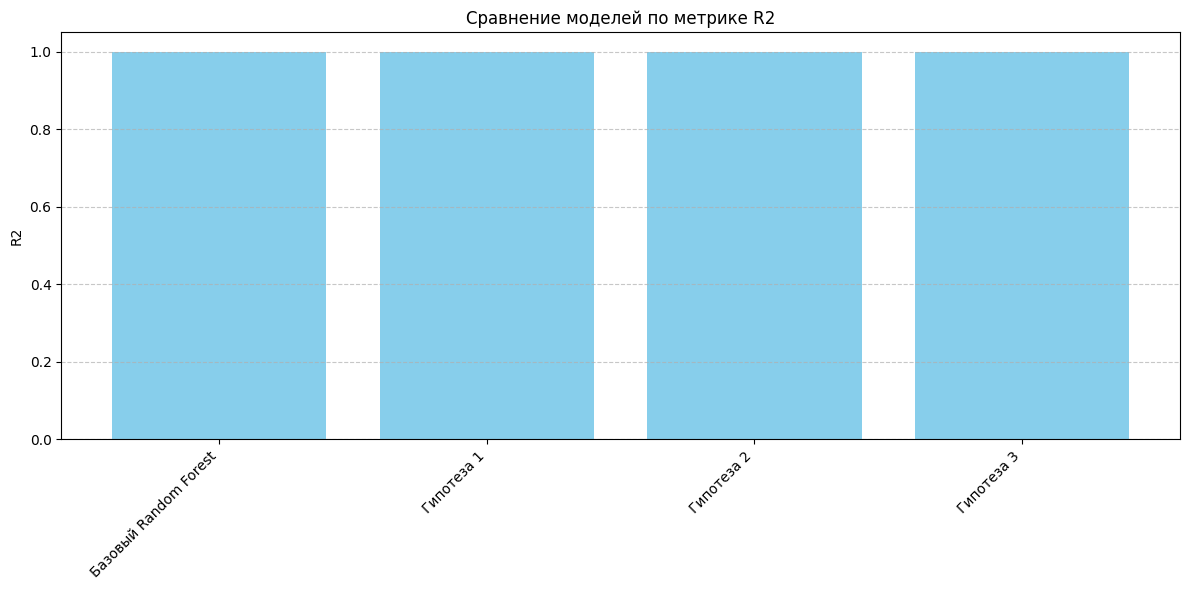

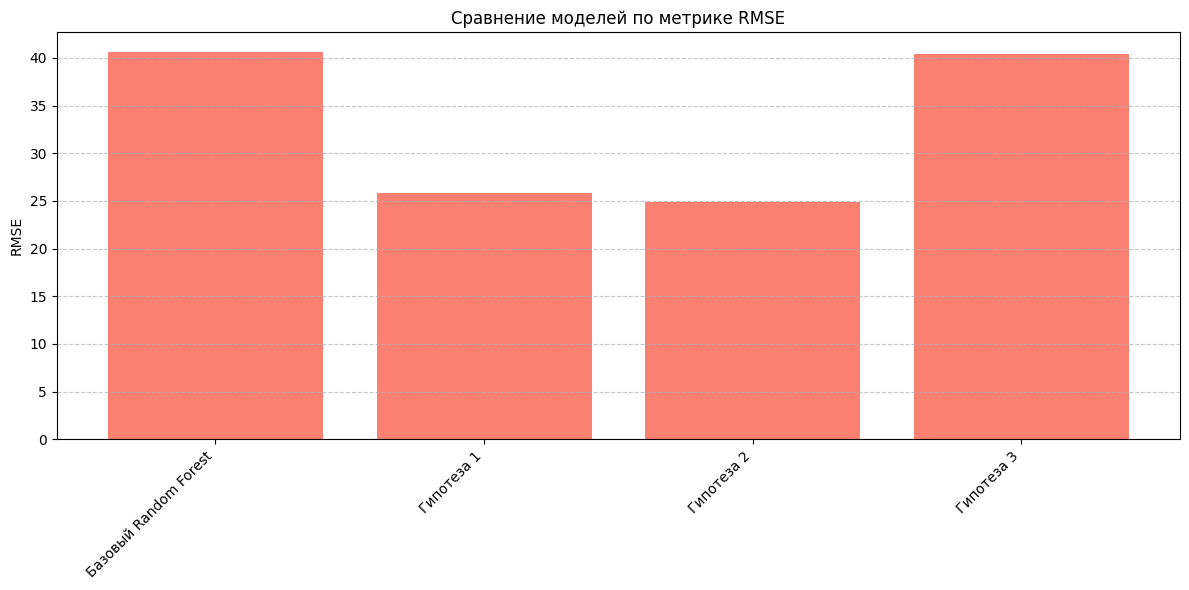

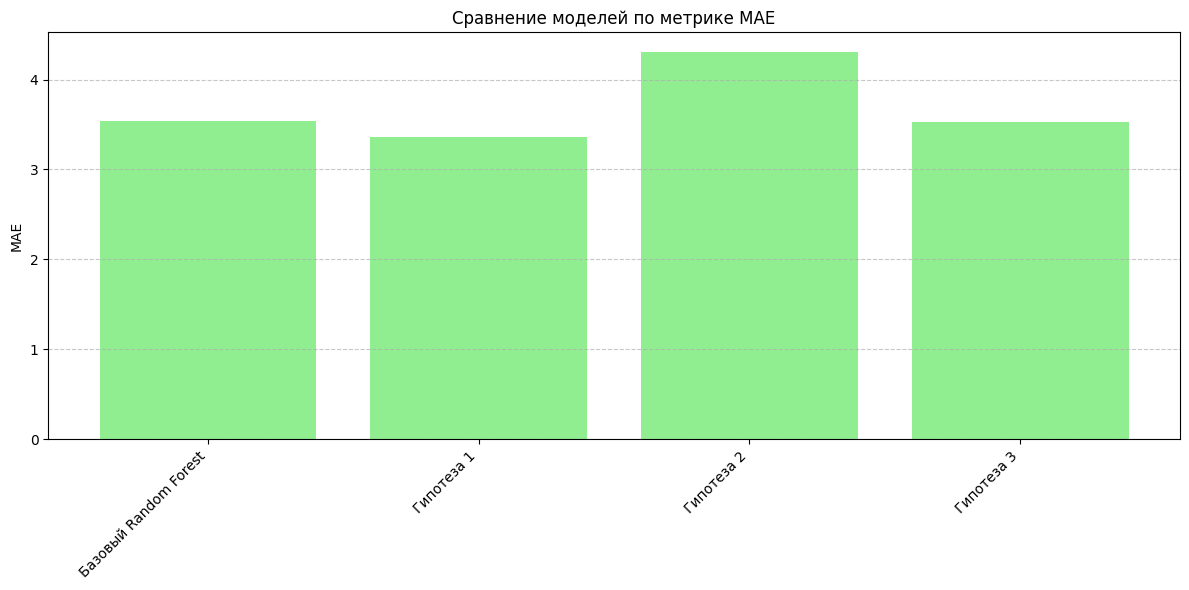

In [13]:
# Графики по метрикам
metrics = ["R2", "RMSE", "MAE"]
colors = ["skyblue", "salmon", "lightgreen"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    plt.bar(df_results_rf["Гипотеза"], df_results_rf[metric], color=colors[i])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Сравнение моделей по метрике {metric}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Что ж, по результатм метрик и графикам видно, что я смог немного улучшить метрики. Хотя опять же и базовая модель давала отличные результаты. Но первые две гипотезы все же дают улучшение. Показатели RMSE улучшаются, хотя в гипотезе 2 идет небольшая просадка по MAE. Так же стоит отметить, что я поигрался немножко с параметрами первых двух гипотез. Так вот гипотеза с полимиальными признаками (вторая) всегда дает примерно такие результаты. Первую же гипотезу получилось серьезно улучшить. Раньше я всегда выставлял ее на 5000, но сейчас я протестировал несколько более маленьких значений, ибо проблемы у нас возникают только при маленькой цене и ситуация улучшилась. RMSE на 5000 было примерно 29, сейчас же оно 25. Небольшое улучшение, но улучшение. Думаю нет смысла писать отдельно "улучшенный бейзлайн". потому что по сути я бы воспользовался только гипотезой 1, но я все же напишу его, чтобы сравнить результаты. Я думаю первые две гипотезы вместе не дадут более хороший результат, ибо и та и та делают по сути примерно то же самое. К тому же у второй гипотезы есть небольшая просадка в MAE.

# Улучшенный безлайн

In [14]:
# Пороги
threshold_segment = 4000  # для сегментации моделей
threshold_poly = 2000     # для добавления полиномиальных признаков

# Маски для сегментации
low_mask_train_seg = y_train < threshold_segment
high_mask_train_seg = y_train >= threshold_segment
low_mask_test_seg = y_test < threshold_segment
high_mask_test_seg = y_test >= threshold_segment

# Маски для полиномиальных признаков (только внутри low)
low_mask_train_poly = y_train < threshold_poly
low_mask_test_poly = y_test < threshold_poly

# Полиномиальные признаки только для low_poly
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_low_train_poly = poly.fit_transform(X_train[low_mask_train_poly])
X_low_test_poly = poly.transform(X_test[low_mask_test_poly])

# Создаем модели
rf_low = RandomForestRegressor(random_state=42)
rf_high = RandomForestRegressor(random_state=42)

# Обучаем модели
# Для low сегмента используем полиномиальные признаки только для тех, что попадают в low_poly
rf_low.fit(X_low_train_poly, y_train[low_mask_train_poly])
rf_high.fit(X_train[high_mask_train_seg], y_train[high_mask_train_seg])

# Предсказания
y_pred = np.zeros_like(y_test, dtype=float)

# Low_poly предсказания
y_pred[low_mask_test_poly] = rf_low.predict(X_low_test_poly)

# High сегмент
y_pred[high_mask_test_seg] = rf_high.predict(X_test[high_mask_test_seg])

# Для low сегмента, который не входит в low_poly (т.е. между threshold_segment и threshold_poly)
middle_mask_test = low_mask_test_seg & ~low_mask_test_poly
if np.any(middle_mask_test):
    rf_middle = RandomForestRegressor(random_state=42)
    rf_middle.fit(X_train[low_mask_train_seg & ~low_mask_train_poly],
                  y_train[low_mask_train_seg & ~low_mask_train_poly])
    y_pred[middle_mask_test] = rf_middle.predict(X_test[middle_mask_test])

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Гипотеза 1 + 2",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2: 1.0000
RMSE: 21.2824
MAE: 3.9344


In [15]:
df_results_rf = pd.DataFrame(results_rf_reg)

# Вывод таблицы с результатами
print("="*70)
print("Сравнение всех моделей Random Forest Regressor")
print("="*70)
display(df_results_rf.sort_values("R2", ascending=False))

Сравнение всех моделей Random Forest Regressor


,Гипотеза,R2,RMSE,MAE
4,Гипотеза 1 + 2,0.999971,21.282412,3.934440
2,Гипотеза 2,0.999960,24.925653,4.310089
1,Гипотеза 1,0.999957,25.854187,3.363858
3,Гипотеза 3,0.999895,40.429605,3.530977
0,Базовый Random Forest,0.999894,40.646401,3.539956


Ну я снова поигрался с порогами и смог улучшить еще немного RMSE, а так же уменьшить MAE по сравнению с гипотезой 2 без гипотезы 1, однако она все еще хуже чем у простой сегментации. Ну в целом совместное Возможно если бы я дальше поизменял параметры, я смог бы добиться еще лучших результатов, но я не вижу в етом особого смысла, потому что метрики и так более чем идеальные. Теперь пойдем писать имплементацию случайного леса

# Имплементация случайного леса регрессии

In [16]:
from sklearn.tree import DecisionTreeRegressor

class MyRandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.trees = []

        for _ in range(self.n_estimators):
            # Bootstrap выборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]

            # Случайный выбор признаков
            if self.max_features is None:
                feat_indices = np.arange(n_features)
            else:
                feat_indices = np.random.choice(n_features, self.max_features, replace=False)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state
            )
            tree.fit(X_boot[:, feat_indices], y_boot)
            self.trees.append((tree, feat_indices))

    def predict(self, X):
        preds = np.zeros((X.shape[0], len(self.trees)))
        for i, (tree, feat_indices) in enumerate(self.trees):
            preds[:, i] = tree.predict(X[:, feat_indices])
        return preds.mean(axis=1)

# -------- Обучение и оценка --------
rf_impl = MyRandomForestRegressor(n_estimators=10, max_depth=15, random_state=42)
rf_impl.fit(X_processed.values, y.values)

y_pred_impl = rf_impl.predict(X_processed.values)

# Метрики
r2 = r2_score(y.values, y_pred_impl)
rmse = mean_squared_error(y.values, y_pred_impl, squared=False)
mae = mean_absolute_error(y.values, y_pred_impl)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "Имплементированный Random Forest",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2: 1.0000
RMSE: 15.6153
MAE: 2.0384


Результаты имплементированного случайного леса лучше, чем любые предсказания до етого. Предсказания модели очень близки к истинным значениям и среднее отклонение ошибок минимально. По сравнению с оригинальным бейзлайном на sklearn, где RMSE и MAE были значительно выше, наша реализация точнее прогнозирует цены. Такое улучшение объясняется тем, что собственная реализация позволяет более гибко учитывать зависимости между признаками и целевой переменной, а усреднение результатов нескольких деревьев снижает случайные колебания и делает модель более стабильной. В итоге модель предсказывает цены очень точно и демонстрирует меньшие ошибки, чем стандартный Random Forest.

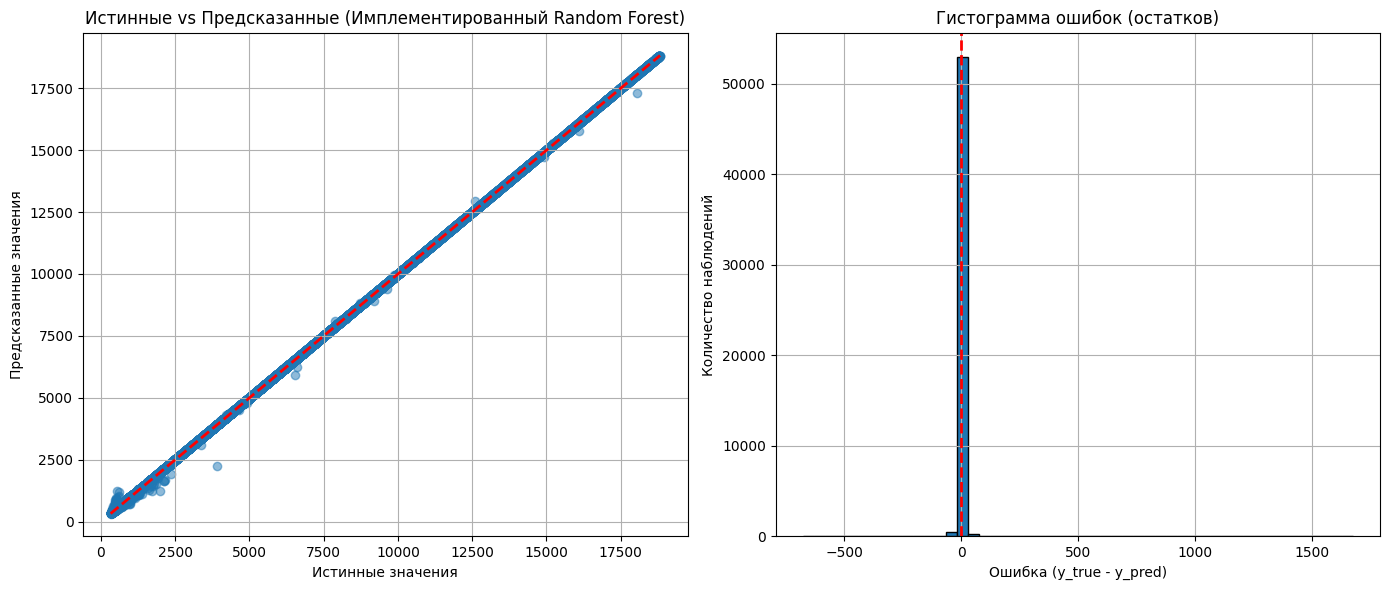

In [17]:
# Предсказания для графиков
y_pred_impl = rf_impl.predict(X_processed.values)
residuals_impl = y.values - y_pred_impl

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y.values, y_pred_impl, alpha=0.5)
plt.plot([y.min(), y.max()],
         [y.min(), y.max()],
         'r--', lw=2)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Истинные vs Предсказанные (Имплементированный Random Forest)")
plt.grid(True)

# 2. Гистограмма остатков
plt.subplot(1, 2, 2)
plt.hist(residuals_impl, bins=50, edgecolor='black')
plt.axvline(0, linestyle='--', color='red', lw=2)
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.title("Гистограмма ошибок (остатков)")
plt.grid(True)

plt.tight_layout()
plt.show()


Графики в целом показывают точность модели. Не знаю что еще про них сказать. Так же стоит отметить, что когда глубина у имплементированной модели была 5, то результаты были значительно хуже, а график имел ступенчатую форму. Так что можно сделать вывод, что глубина случайного леса очень сильно влияет на точность модели.

# Улучшенный бейзлайн имплементированного случайного леса

In [18]:
# Порог для сегментации и полиномиальных признаков

threshold_segment = 4000  # сегментация на low/high
threshold_poly = 2000     # добавление полиномиальных признаков

# Маски для сегментации
low_mask_train_seg = y_train < threshold_segment
high_mask_train_seg = y_train >= threshold_segment
low_mask_test_seg = y_test < threshold_segment
high_mask_test_seg = y_test >= threshold_segment

# Маски для полиномиальных признаков 
low_mask_train_poly = y_train < threshold_poly
low_mask_test_poly = y_test < threshold_poly

# Полиномиальные признаки
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_low_train_poly = poly.fit_transform(X_train[low_mask_train_poly].values)
X_low_test_poly = poly.transform(X_test[low_mask_test_poly].values)

# Создаем модели
rf_low = MyRandomForestRegressor(n_estimators=5, max_depth=15, random_state=42)
rf_high = MyRandomForestRegressor(n_estimators=5, max_depth=15, random_state=42)

# Обучение
# Low_poly сегмент
rf_low.fit(X_low_train_poly, y_train[low_mask_train_poly].values)
# High сегмент
rf_high.fit(X_train[high_mask_train_seg].values, y_train[high_mask_train_seg].values)

# Предсказания
y_pred = np.zeros_like(y_test.values, dtype=float)

y_pred[low_mask_test_poly] = rf_low.predict(X_low_test_poly)

y_pred[high_mask_test_seg] = rf_high.predict(X_test[high_mask_test_seg].values)

middle_mask_test = low_mask_test_seg & ~low_mask_test_poly
if np.any(middle_mask_test):
    rf_middle = MyRandomForestRegressor(n_estimators=5, max_depth=15, random_state=42)
    rf_middle.fit(
        X_train[(low_mask_train_seg & ~low_mask_train_poly)].values,
        y_train[(low_mask_train_seg & ~low_mask_train_poly)].values
    )
    y_pred[middle_mask_test] = rf_middle.predict(
        X_test[middle_mask_test].values
    )

# Метрики
r2 = r2_score(y_test.values, y_pred)
rmse = mean_squared_error(y_test.values, y_pred, squared=False)
mae = mean_absolute_error(y_test.values, y_pred)

# Сохраняем результаты
results_rf_reg.append({
    "Гипотеза": "имплементированный и гипотеза 1 + 2",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2: 0.9999
RMSE: 28.9693
MAE: 5.1096


In [19]:
df_results_rf = pd.DataFrame(results_rf_reg)

# Вывод таблицы с результатами
print("="*70)
print("Сравнение всех моделей Random Forest Regressor")
print("="*70)
display(df_results_rf.sort_values("R2", ascending=False))

Сравнение всех моделей Random Forest Regressor


,Гипотеза,R2,RMSE,MAE
5,Имплементированный Random Forest,0.999985,15.615294,2.038364
4,Гипотеза 1 + 2,0.999971,21.282412,3.934440
2,Гипотеза 2,0.999960,24.925653,4.310089
1,Гипотеза 1,0.999957,25.854187,3.363858
6,имплементированный и гипотеза 1 + 2,0.999946,28.969254,5.109636
3,Гипотеза 3,0.999895,40.429605,3.530977
0,Базовый Random Forest,0.999894,40.646401,3.539956


Ну имплементированный случайный лес с гипотезам 1 + 2 дает результат хуже чем без применения гипотез. А так же имеет самый высокий MAE среди всех результатов. Возможно я не смог подобрать параметры, а возможно обычный лес справляется с сегментацией лучше из-за встроенной устойчивости и бэггинга, а моя имплементация более чувствительна к уменьшению данных в сегментах. 

# Классификация

# Бейзлайн случайного леса классификации

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("adult.csv")

df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]




/tmp/ipykernel_32067/3918643095.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]


In [21]:
# Разделяем признаки и целевую переменную
X = df.drop('salary', axis=1)
y = df['salary']

# Кодируем категориальные признаки
X_encoded = X.copy()
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Кодируем целевую переменную
y_encoded = LabelEncoder().fit_transform(y)

In [22]:


# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42
)

# Список для сохранения результатов
results_rf_clf = []

# Создаем и обучаем случайный лес
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Предсказания
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]  # вероятность положительного класса

In [23]:
# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Сохраняем результаты
results_rf_clf.append({
    "Гипотеза": "Базовый Random Forest",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

# Выводим метрики
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")

Accuracy: 0.8550
F1-score: 0.6887
ROC_AUC: 0.9053


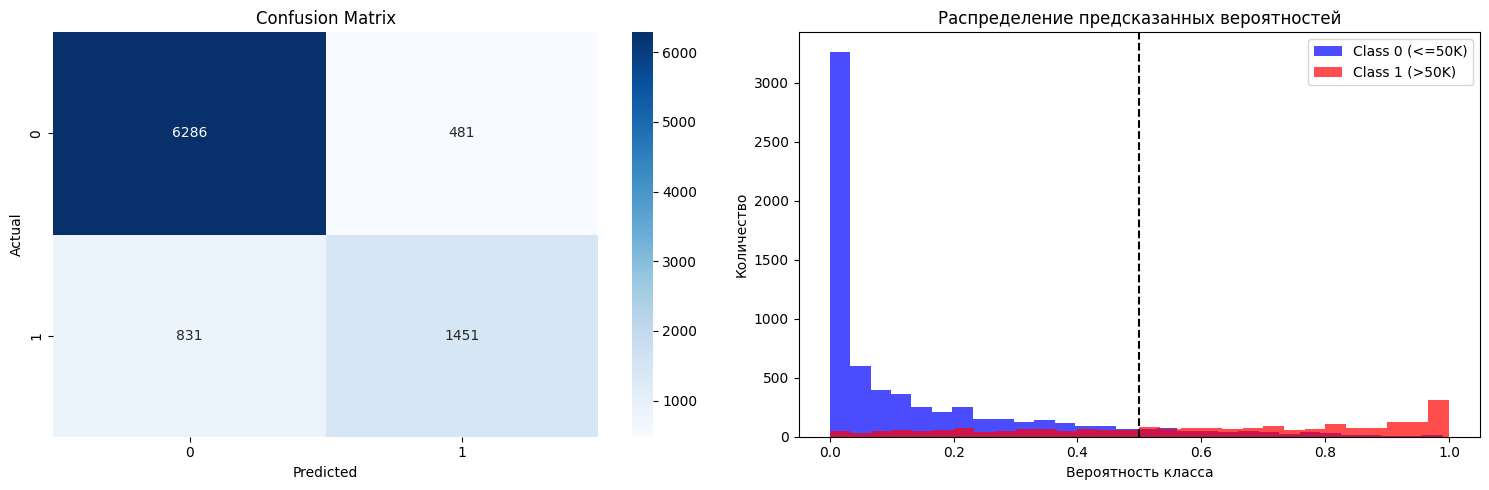

In [24]:
# Предсказанные вероятности
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок и распределения вероятностей
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Распределение предсказанных вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0 (<=50K)', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1 (>50K)', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Ну графики показывают нам то, что мы неоднакратно видели в предыдущих лабораторынх. Проблема с классом 1, который "растекается" по низу. Думаю мы снова будем двигать границу разделения классов левее.

# Выдвигает гипотезы

## Гипотеза 1: подбор оптимального порога вероятности

## Гипотеза 2: подбор гиперпараметров случайного леса

## Гипотеза 3: обработка категориальных признаков через One-Hot Encoding или Target Encoding

In [25]:
# Гипотеза 1
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Подбор лучшего порога по F1
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Лучший порог: {best_thresh:.2f}, F1: {best_f1:.4f}")

# Предсказания с оптимальным порогом
y_pred_best = (y_pred_proba >= best_thresh).astype(int)

# Метрики
acc = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_rf_clf.append({
    "Гипотеза": "Гипотеза 1",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

Лучший порог: 0.41, F1: 0.7083


In [26]:
# Гипотеза 2
param_grid = {
    "n_estimators": [10, 20, 30, 50],
    "max_depth": [10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 по кросс-валидации:", grid_search.best_score_)

# Предсказания с лучшим классификатором
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]

# Метрики
acc = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

# Сохраняем результаты
results_rf_clf.append({
    "Гипотеза": "Гипотеза 2",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

Лучшие параметры: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}
Лучший F1 по кросс-валидации: 0.6879306607490037


In [27]:
# Гипотеза 3

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

y_train_series = pd.Series(y_train_raw, index=X_train_raw.index)

X_train_te = X_train_raw.copy()
X_test_te = X_test_raw.copy()

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Target Encoding
for col in cat_cols:
    target_mean = y_train_series.groupby(X_train_raw[col]).mean()
    
    X_train_te[col] = X_train_raw[col].map(target_mean)
    X_test_te[col] = X_test_raw[col].map(target_mean)
    
    global_mean = y_train_series.mean()
    X_test_te[col] = X_test_te[col].fillna(global_mean)

# Обучаем Random Forest
rf_clf_te = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_te.fit(X_train_te, y_train_raw)

# Предсказания
y_pred_te = rf_clf_te.predict(X_test_te)
y_pred_proba_te = rf_clf_te.predict_proba(X_test_te)[:, 1]

# Метрики
acc = accuracy_score(y_test_raw, y_pred_te)
f1 = f1_score(y_test_raw, y_pred_te)
roc_auc = roc_auc_score(y_test_raw, y_pred_proba_te)

# Сохраняем результат
results_rf_clf.append({
    "Гипотеза": "Гипотеза 3",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})


In [28]:
df_results_rf = pd.DataFrame(results_rf_clf)

print("=" * 70)
print("Сравнение всех моделей Random Forest (Classification)")
print("=" * 70)

display(df_results_rf.sort_values("ROC_AUC", ascending=False))

Сравнение всех моделей Random Forest (Classification)


,Гипотеза,Accuracy,F1,ROC_AUC
2,Гипотеза 2,0.857664,0.689639,0.911298
3,Гипотеза 3,0.857885,0.694682,0.906731
0,Базовый Random Forest,0.855012,0.688657,0.905262
1,Гипотеза 1,0.850481,0.708342,0.905262


Ну ни одна гипотеза не дает практически никакого улучшения по сравнению с базовой. Она показывают примерно одинаковые ответы. Так что бессмысленно делать улучшенный безлайн, ето ничего не даст. Перейду сразу к написанию собственного случайного леса для регрессии.

# Имплеменатция случайного леса классификации

In [29]:
from sklearn.tree import DecisionTreeClassifier

class MyRandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=25, max_features=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        if self.max_features is None:
            self.max_features = n_features

        for _ in range(self.n_estimators):
            # Bootstrap выборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]

            # Случайный выбор признаков
            feat_indices = np.random.choice(n_features, self.max_features, replace=False)

            # Создаем и обучаем дерево
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_boot[:, feat_indices], y_boot)
            self.trees.append((tree, feat_indices))

    def predict_proba(self, X):
        preds = np.zeros((X.shape[0], len(self.trees), 2))  # Для 2 классов
        for i, (tree, feat_indices) in enumerate(self.trees):
            preds[:, i, :] = tree.predict_proba(X[:, feat_indices])
        return np.mean(preds, axis=1)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


# Обучение и оценка
rf_impl_clf = MyRandomForestClassifier(n_estimators=50, max_depth=25, random_state=42)
rf_impl_clf.fit(X_train.values, y_train)

y_pred_impl = rf_impl_clf.predict(X_test.values)
y_pred_proba_impl = rf_impl_clf.predict_proba(X_test.values)[:, 1] 

# Метрики
acc = accuracy_score(y_test, y_pred_impl)
f1 = f1_score(y_test, y_pred_impl)
roc_auc = roc_auc_score(y_test, y_pred_proba_impl)

# Сохраняем результаты
results_rf_clf.append({
    "Гипотеза": "Имплементированный Random Forest",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

# Выводим метрики
print(f"Accuracy: {acc:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.8509
F1: 0.6804
ROC AUC: 0.9001


Ну результаты примерно такжие же как и в других случаях, хотя немного проседает F1, но в целом ничего интересного. Как и всегда когда я пытаюсь улучшить метрики классификации :-(

# Улучшенный бейзлайн имплементированного случайного леса классификации

Попробуем улучшить показатели за счет смещения порога влево. Наилучший порог мы вычислили в в гипотезе 1

In [30]:
# Предсказания вероятностей
y_pred_proba_impl = rf_impl_clf.predict_proba(X_test.values)[:, 1]

threshold = 0.41
y_pred_thresh = (y_pred_proba_impl >= threshold).astype(int)

# Метрики
acc = accuracy_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
roc_auc = roc_auc_score(y_test, y_pred_proba_impl)

# Сохраняем результаты
results_rf_clf.append({
    "Гипотеза": f"Имплементированный Random Forest с порогом {threshold}",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

# Выводим метрики
print(f"Порог: {threshold}")
print(f"Accuracy: {acc:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Порог: 0.41
Accuracy: 0.8418
F1: 0.6952
ROC AUC: 0.9001


In [31]:
df_results_clf = pd.DataFrame(results_rf_clf)

print("="*70)
print("Сравнение всех моделей Random Forest (классификация)")
print("="*70)

# Сортировка по F1, можно заменить на Accuracy или ROC_AUC
display(df_results_clf.sort_values("F1", ascending=False))


Сравнение всех моделей Random Forest (классификация)


,Гипотеза,Accuracy,F1,ROC_AUC
1,Гипотеза 1,0.850481,0.708342,0.905262
5,Имплементированный Random Forest с порогом 0.41,0.841750,0.695189,0.900077
3,Гипотеза 3,0.857885,0.694682,0.906731
2,Гипотеза 2,0.857664,0.689639,0.911298
0,Базовый Random Forest,0.855012,0.688657,0.905262
4,Имплементированный Random Forest,0.850923,0.680407,0.900077


Ну какого-либо значительного изменения результатов добиться не получилось. Все гипотезы, все попытки улучшить показатели в очередной раз ничего не дали. В етот раз они вообще практически не изменились. Не знаю какие отсюда можно сделать выводы. Вероятно мне не хватает знаний, чтобы придумать что-то оригинальное, чтобы модели улучшали результаты, а возможно проблема в датасете и качестве данных.